## Load packages

In [1]:
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.ui import with_ui_cbk

from deafrica_tools.plotting import display_map
from deafrica_tools.spatial import xr_rasterize
import os

from datacube.utils import geometry
from deafrica_tools.classification import collect_training_data
from odc.io.cgroups import get_cpu_quota
from feature_collection import feature_layers
from datetime import datetime
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

## Import training polygons

In [2]:
# Point to crop type training data
input_folder="data"
output_crs="EPSG:32736"
output_folder="results"
path= os.path.join(input_folder,"Cash_crop_type_formatted.geojson")
gpd_crop_types = gpd.read_file(path).to_crs(output_crs)
gpd_crop_types.head()

,year,Crop_type,maize,sesame,soy,others,geometry
0,2021,Maize,1,0,0,0,"POLYGON ((604985.946 7872596.580, 604974.726 7..."
1,2021,Maize and soy,1,0,1,0,"POLYGON ((549969.228 7886718.142, 549969.228 7..."
2,2021,Maize,1,0,0,0,"POLYGON ((605274.155 7872593.428, 605290.545 7..."
3,2021,"Bean, sesame and maize",1,1,0,1,"MULTIPOLYGON (((559570.536 7877573.399, 559570..."
4,2021,Sesame,0,1,0,0,"POLYGON ((882127.657 8142716.654, 882121.082 8..."


## Load datacube

define feature layers

In [3]:
query = {
    'time': ("2021-10","2022-09"),
    'measurements': ['ndvi_mean'],
    'output_crs': output_crs,
    'resolution': (-30, 30)
}
# define a function to feature layers
def feature_layers(query): 
    #connect to the datacube
    dc = datacube.Datacube(app='NDVI_anomaly')
    ds = dc.load(product="ndvi_anomaly",
                  group_by='solar_day',
                  **query)
    # stack multi-temporal measurements and rename them
    n_time=ds.dims['time']
    list_measurements=list(ds.keys())
    ds_stacked=None
    for j in range(len(list_measurements)):
        for k in range(n_time):
            variable_name=list_measurements[j]+'_'+str(k)
            measure_single=ds[list_measurements[j]].isel(time=k).rename(variable_name)
            if ds_stacked is None:
                ds_stacked=measure_single
            else:
                ds_stacked=xr.merge([ds_stacked,measure_single],compat='override')
    return ds_stacked

extract training data for each class

In [4]:
class_fields=['maize','sesame','soy','others']
NDVIs_all=[]
# Collect the training data
for class_field in class_fields:
    print('extracting data for ',class_field)
    # select exclusive training samples per class
    other_fields=class_fields.copy()
    other_fields.remove(class_field) # note this method implements in place
    single_crops_subset=gpd_crop_types[gpd_crop_types[class_field]==1]
    single_crops_subset.drop(single_crops_subset[single_crops_subset[other_fields].any(axis=1)].index,axis=0,inplace=True)
    single_crops_subset.reset_index(inplace=True)
    column_names, model_input = collect_training_data(
        gdf=single_crops_subset,
        dc_query=query,
        ncpus=35,
        field=class_field,
        zonal_stats='mean',
        feature_func=feature_layers,
    )
    output_file = os.path.join(output_folder,'crop_types_monthly_NDVI_'+class_field+'.txt')
    #grab all columns
    model_col_indices = [column_names.index(var_name) for var_name in column_names]
    #Export files to disk
    np.savetxt(output_file, model_input[:, model_col_indices], header=" ".join(column_names), fmt="%4f")
    #append to list
    NDVIs_all.append(model_input[:,1:].T)

extracting data for  maize
Taking zonal statistic: mean


/tmp/ipykernel_454/4238194127.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_crops_subset.drop(single_crops_subset[single_crops_subset[other_fields].any(axis=1)].index,axis=0,inplace=True)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  0%|          | 0/60 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 1.67 %
Removed 16 rows wth NaNs &/or Infs
Output shape:  (44, 13)
extracting data for  sesame
Taking zonal statistic: mean


/tmp/ipykernel_454/4238194127.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_crops_subset.drop(single_crops_subset[single_crops_subset[other_fields].any(axis=1)].index,axis=0,inplace=True)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  0%|          | 0/53 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 5.66 %
Recollecting samples that failed


  0%|          | 0/3 [00:00<?, ?it/s]

Percentage of possible fails after run 2 = 5.66 %
Recollecting samples that failed


  0%|          | 0/3 [00:00<?, ?it/s]

Percentage of possible fails after run 3 = 5.66 %
Recollecting samples that failed


  0%|          | 0/3 [00:00<?, ?it/s]

Removed 8 rows wth NaNs &/or Infs
Output shape:  (45, 13)
extracting data for  soy
Taking zonal statistic: mean


/tmp/ipykernel_454/4238194127.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_crops_subset.drop(single_crops_subset[single_crops_subset[other_fields].any(axis=1)].index,axis=0,inplace=True)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  0%|          | 0/13 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 7.69 %
Recollecting samples that failed


  0%|          | 0/1 [00:00<?, ?it/s]

Percentage of possible fails after run 2 = 7.69 %
Recollecting samples that failed


  0%|          | 0/1 [00:00<?, ?it/s]

Percentage of possible fails after run 3 = 7.69 %
Recollecting samples that failed


  0%|          | 0/1 [00:00<?, ?it/s]

Removed 6 rows wth NaNs &/or Infs
Output shape:  (7, 13)
extracting data for  others
Taking zonal statistic: mean


/tmp/ipykernel_454/4238194127.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_crops_subset.drop(single_crops_subset[single_crops_subset[other_fields].any(axis=1)].index,axis=0,inplace=True)
/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  0%|          | 0/110 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 3.64 %
Recollecting samples that failed


  0%|          | 0/4 [00:00<?, ?it/s]

Percentage of possible fails after run 2 = 3.64 %
Recollecting samples that failed


  0%|          | 0/4 [00:00<?, ?it/s]

Percentage of possible fails after run 3 = 3.64 %
Recollecting samples that failed


  0%|          | 0/4 [00:00<?, ?it/s]

Removed 9 rows wth NaNs &/or Infs
Output shape:  (101, 13)


## Plot NDVI phenology

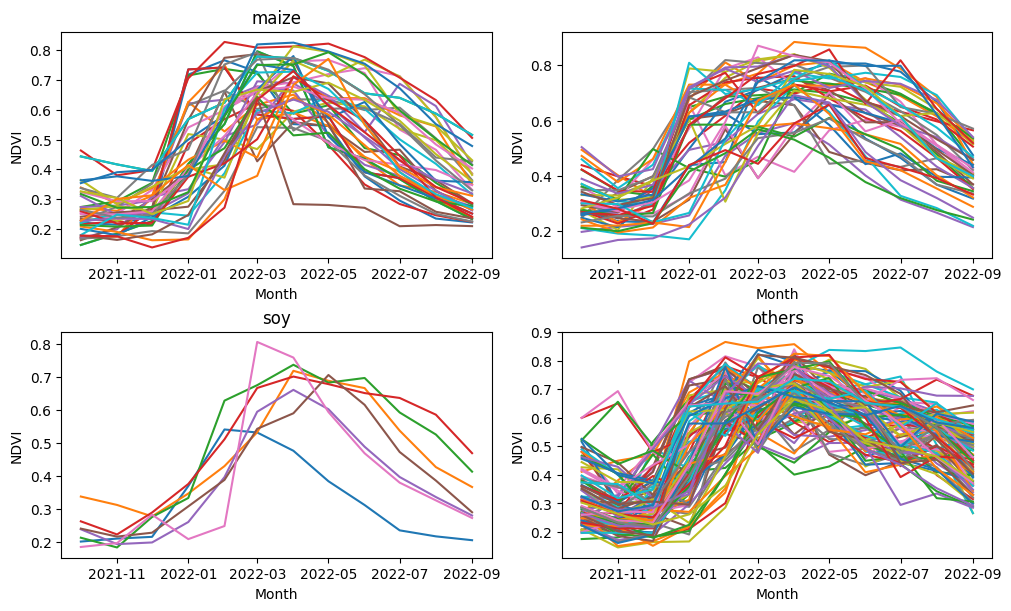

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
x_labels = [datetime(2021, x,1) for x in [10,11,12]]
x_labels.extend([datetime(2022,x,1) for x in range(1,10)])
for ax,class_field,NDVIs in zip(axs.flat,class_fields,NDVIs_all):
    ax.plot(x_labels,NDVIs)
    ax.set_title(class_field)
    ax.set_xlabel('Month')
    ax.set_ylabel('NDVI')

plot median across polygons

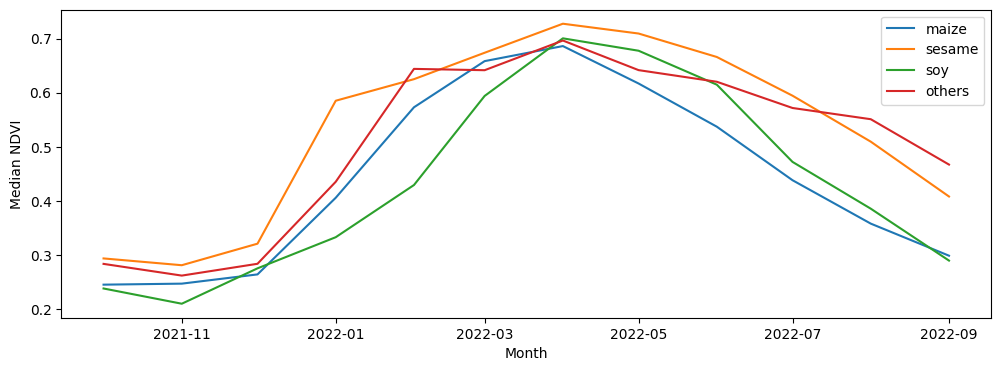

In [6]:
plt.figure(figsize=(12,4))
for class_field,NDVIs in zip(class_fields,NDVIs_all):
    plt.plot(x_labels,np.median(NDVIs,axis=1),label=class_field)
plt.xlabel("Month")
plt.ylabel("Median NDVI")
plt.legend()
plt.show()

plot mean across polygons

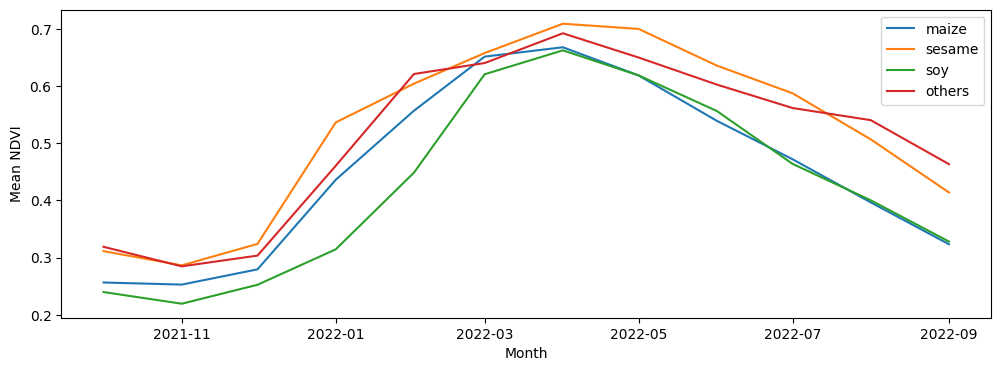

In [7]:
plt.figure(figsize=(12,4))
for class_field,NDVIs in zip(class_fields,NDVIs_all):
    plt.plot(x_labels,np.mean(NDVIs,axis=1),label=class_field)
plt.xlabel("Month")
plt.ylabel("Mean NDVI")
plt.legend()
plt.show()